### Credit card approvals dataset classification models

to do 
- add explanatory notes
- do something with feature exploration?
- make evaluation of different models more consistend eg accuracy, roc, confusion matrix
- add confusion matrix

Then export code and save model

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from tqdm.auto import tqdm
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn import metrics

Import and clean up

In [7]:
df = pd.read_csv('cc_approvals.csv')

In [8]:
# add column names
df.columns = ['gender', 'age', 'debt', 'married', 'bankcustomer', 'educationlevel',
       'ethnicity', 'yearsemployed', 'priordefault', 'employed', 'creditscore',
       'driverslicense', 'citizen', 'zipcode', 'income', 'approvalstatus']

In [5]:
df.head()

gender    age   debt married bankcustomer educationlevel ethnicity  \
0      a  58.67  4.460       u            g              q         h   
1      a  24.50  0.500       u            g              q         h   
2      b  27.83  1.540       u            g              w         v   
3      b  20.17  5.625       u            g              w         v   
4      b  32.08  4.000       u            g              m         v   

   yearsemployed priordefault employed  creditscore driverslicense citizen  \
0           3.04            t        t            6              f       g   
1           1.50            t        f            0              f       g   
2           3.75            t        t            5              t       g   
3           1.71            t        f            0              f       s   
4           2.50            t        f            0              t       g   

  zipcode  income approvalstatus  
0   00043     560              +  
1   00280     824              +  
2   00100       3              +  
3   00120       0              +  
4   00360       0              +

In [9]:
# check for null values
df.columns.isnull()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [10]:
# replace string characters with integers
df.approvalstatus = df.approvalstatus.replace('+', 1)
df.approvalstatus = df.approvalstatus.replace('-', 0)
df = df.replace('?',0 )

Text(0.5, 1.0, 'Credit card approvals')

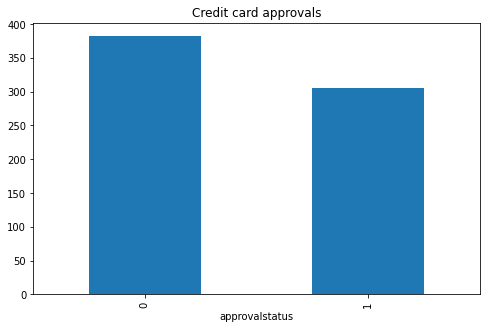

In [67]:
# plot to show distribution
data = df['approvalstatus'].value_counts()
data.plot(kind='bar',figsize=(8,5))
plt.title('Credit card approvals')

In [11]:
# find correlations in the data with correlation matrix
df_num = df[['age', 'debt', 'yearsemployed', 'zipcode', 'income']]
matrix = df_num.corr()
matrix

age      debt  yearsemployed   zipcode    income
age            1.000000  0.199616       0.360449 -0.095583  0.019334
debt           0.199616  1.000000       0.298714 -0.217879  0.122935
yearsemployed  0.360449  0.298714       1.000000 -0.070448  0.051267
zipcode       -0.095583 -0.217879      -0.070448  1.000000  0.059272
income         0.019334  0.122935       0.051267  0.059272  1.000000

In [30]:
# test feature importance with auc

col = ['age', 'debt', 'yearsemployed', 'zipcode', 'income']
for c in col:
    print(c + '   ' + str(roc_auc_score(df.approvalstatus, df[c])).rjust(40 - len(c)))

age                      0.5959999317394494
debt                     0.6124891209747607
yearsemployed            0.7201744057065822
zipcode                 0.42335193433335044
income                   0.6587569753750064


##### Split dataframe and prepare for models

In [11]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=2)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=2)
len(df_full_train), len(df_test), len(df_train), len(df_val)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

target = 'approvalstatus'
y_full_train = df_full_train[target]
y_test = df_test[target]
y_train = df_train[target]
y_val = df_val[target]

del df_full_train[target]
del df_test[target]
del df_train[target]
del df_val[target]

Train Logistic Regression and validate model

In [33]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)


In [34]:

model = LogisticRegression(solver='liblinear', C=0.1, max_iter=1000, random_state=2)
model.fit(X_train, y_train)

LogisticRegression(C=0.1, max_iter=1000, random_state=2, solver='liblinear')

In [35]:
# calculate accuracy
y_pred = model.predict_proba(X_val)[:,1]
y_pred_bool = (y_pred >= 0.5).astype(int)
(y_val == y_pred_bool).mean()

0.8260869565217391

In [36]:
df_pred = pd.DataFrame()
df_pred['actual'] = y_val
df_pred['probability'] = y_pred
df_pred['prediction'] = y_pred_bool.astype(int)
df_pred['correct'] = df_pred.prediction == df_pred.actual
df_pred.correct.mean().round(4)

0.8261

In [39]:
# calculate roc auc score

lr_val_auc = roc_auc_score(y_val,y_pred_bool)
lr_val_auc

0.8203108367042793

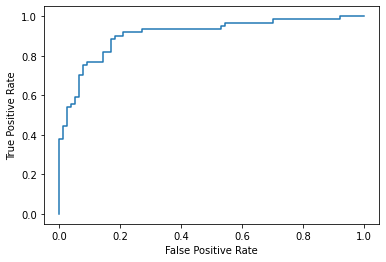

In [46]:
# plot ROC curve

fpr, tpr, _ = metrics.roc_curve(y_val,  y_pred)

plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Model Evaluation - AUC, thresholds, f-score, kfold to refine c

In [47]:
thresholds = np.arange(0, 1.0, 0.01)
prec = []
rec = []
for t in thresholds:

    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    p = tp / (tp + fp)
    r = tp / (tp + fn)

    prec.append(p)
    rec.append(r)

columns = [ 'thresholds','prec', 'rec']
scores = [thresholds, prec, rec]
#df['column_name']=pd.Series(arr)
df_scores = pd.DataFrame(scores, columns)
df_scores = df_scores.T
df_scores

thresholds      prec       rec
0         0.00  0.442029  1.000000
1         0.01  0.442029  1.000000
2         0.02  0.442029  1.000000
3         0.03  0.442029  1.000000
4         0.04  0.442029  1.000000
..         ...       ...       ...
95        0.95  1.000000  0.229508
96        0.96  1.000000  0.213115
97        0.97  1.000000  0.180328
98        0.98  1.000000  0.147541
99        0.99  1.000000  0.114754

[100 rows x 3 columns]

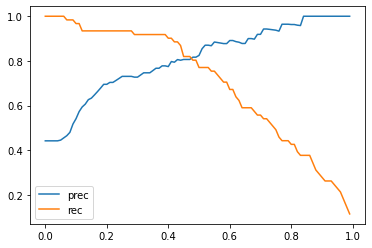

In [48]:
plt.plot(df_scores.thresholds, df_scores['prec'], label='prec')
plt.plot(df_scores.thresholds, df_scores['rec'], label='rec')
plt.legend()

In [49]:
def f1_score(p,r):
    a = p*r
    b = p+r
    c = a/b
    f1 = 2*c
    return f1

In [50]:
df_scores['f1_score'] = df_scores.apply(lambda x: f1_score(x['prec'],x['rec']), axis = 1)
df_scores[df_scores['f1_score'] == df_scores['f1_score'].max()]

thresholds      prec       rec  f1_score
41        0.41  0.797101  0.901639  0.846154

In [51]:
def train(df_train, y_train, C=1.0):

    dicts = df_train.to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver = 'liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [52]:
def predict(df, dv, model):
    dicts = df.to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [54]:
n_splits = 5

for C in tqdm([0.01, 0.1, 0.3, 0.4, 0.5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.approvalstatus.values
        y_val = df_val.approvalstatus.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/6 [00:00<?, ?it/s]

C=0.01 0.959 +- 0.014
C=0.1 0.997 +- 0.003
C=0.3 1.000 +- 0.000
C=0.4 1.000 +- 0.000
C=0.5 1.000 +- 0.000
C=10 1.000 +- 0.000


Tree-based Models - RF and XGBoost

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text
import xgboost as xgb

In [12]:
dv = DictVectorizer(sparse=False)
train_dicts = df_train.fillna(0).to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [13]:
rf = RandomForestClassifier(max_depth = 10)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10)

In [14]:
y_pred = rf.predict(X_val)
roc_auc_score(y_val, y_pred)


0.8332978496912923

##### Test different parameters - RF

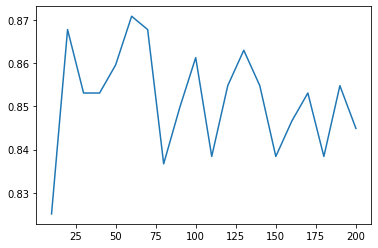

In [15]:
# test number of estimators - how many trees make a forest?

scores = []

for n in range (10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)  
    scores.append((n, roc_auc_score(y_val, y_pred)))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'roc_auc_score'])
plt.plot(df_scores.n_estimators, df_scores.roc_auc_score)    

In [16]:
# estimators and depth of tree

values = [10, 15, 20, 25]
scores = []
for v in values:
    for n in range (10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, random_state=1, n_jobs=-1, max_depth = v)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)  
        scores.append((v, n, roc_auc_score(y_val, y_pred)))
        
df_depth_scores = pd.DataFrame(scores, columns = ['depth', 'estimators', 'roc_auc_score'] )        

In [17]:
df_depth_scores.roc_auc_score.max()

0.8711943793911008

In [18]:
df_depth_scores[df_depth_scores['roc_auc_score'] == df_depth_scores.roc_auc_score.max()]

depth  estimators  roc_auc_score
61     25          20       0.871194

In [22]:
# use parameters from test - best version

rf = RandomForestClassifier(n_estimators=20, random_state=1, n_jobs=-1, max_depth = 25)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)  

roc_auc_score(y_val, y_pred)



0.8711943793911008

Train XGBoost

In [23]:
features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

c:\Users\rlong\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


In [24]:
# first version
watchlist = [(dtrain, 'train'), (dval, 'val')]

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

watchlist = [(dtrain, 'train'), (dval, 'val')]
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200, evals=watchlist)

y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred )

[0]	train-rmse:0.38505	val-rmse:0.42090
[1]	train-rmse:0.30568	val-rmse:0.37547
[2]	train-rmse:0.25033	val-rmse:0.35856
[3]	train-rmse:0.21453	val-rmse:0.34846
[4]	train-rmse:0.18640	val-rmse:0.34373


[5]	train-rmse:0.17509	val-rmse:0.34098
[6]	train-rmse:0.16005	val-rmse:0.34029
[7]	train-rmse:0.15084	val-rmse:0.34179
[8]	train-rmse:0.14311	val-rmse:0.34099
[9]	train-rmse:0.13920	val-rmse:0.34107
[10]	train-rmse:0.13609	val-rmse:0.34105
[11]	train-rmse:0.13368	val-rmse:0.34118
[12]	train-rmse:0.13107	val-rmse:0.33956
[13]	train-rmse:0.12682	val-rmse:0.33945
[14]	train-rmse:0.12370	val-rmse:0.33938
[15]	train-rmse:0.12154	val-rmse:0.33853
[16]	train-rmse:0.11939	val-rmse:0.33833
[17]	train-rmse:0.11716	val-rmse:0.33817
[18]	train-rmse:0.11530	val-rmse:0.33791
[19]	train-rmse:0.11373	val-rmse:0.33783
[20]	train-rmse:0.10948	val-rmse:0.33771
[21]	train-rmse:0.10789	val-rmse:0.33781
[22]	train-rmse:0.10651	val-rmse:0.33819
[23]	train-rmse:0.10520	val-rmse:0.33889
[24]	train-rmse:0.10356	val-rmse:0.33842
[25]	train-rmse:0.10184	val-rmse:0.33715
[26]	train-rmse:0.10054	val-rmse:0.33726
[27]	train-rmse:0.09925	val-rmse:0.33872
[28]	train-rmse:0.09795	val-rmse:0.33939
[29]	train-rmse:0.096

0.8995103257398339

In [42]:
#train etas
watchlist = [(dtrain, 'train'), (dval, 'val')]

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
scores = []
etas = [0.1, 0.3, 0.5, 0.7, 1, 1.5, 2]
for i in etas:
    xgb_params = {
        'eta': i, 
        'max_depth': 6,
        'min_child_weight': 1,
        'objective': 'reg:squarederror',
        'nthread': 8,
        'seed': 1,
        'verbosity': 1,
    }

    model = xgb.train(xgb_params, dtrain, num_boost_round=200, evals=watchlist)

    y_pred = model.predict(dval)
    scores.append((i, roc_auc_score(y_val, y_pred )))

[0]	train-rmse:0.45746	val-rmse:0.46919
[1]	train-rmse:0.42254	val-rmse:0.44505
[2]	train-rmse:0.39074	val-rmse:0.42626
[3]	train-rmse:0.36240	val-rmse:0.41058
[4]	train-rmse:0.33752	val-rmse:0.39806
[5]	train-rmse:0.31496	val-rmse:0.38741
[6]	train-rmse:0.29467	val-rmse:0.37968
[7]	train-rmse:0.27727	val-rmse:0.37255
[8]	train-rmse:0.26170	val-rmse:0.36660
[9]	train-rmse:0.24756	val-rmse:0.36043
[10]	train-rmse:0.23534	val-rmse:0.35613
[11]	train-rmse:0.22595	val-rmse:0.35203
[12]	train-rmse:0.21597	val-rmse:0.35053
[13]	train-rmse:0.20748	val-rmse:0.34995
[14]	train-rmse:0.19892	val-rmse:0.34781
[15]	train-rmse:0.19142	val-rmse:0.34631
[16]	train-rmse:0.18487	val-rmse:0.34733
[17]	train-rmse:0.17963	val-rmse:0.34666
[18]	train-rmse:0.17430	val-rmse:0.34617
[19]	train-rmse:0.16956	val-rmse:0.34660
[20]	train-rmse:0.16579	val-rmse:0.34579
[21]	train-rmse:0.16092	val-rmse:0.34570
[22]	train-rmse:0.15787	val-rmse:0.34622
[23]	train-rmse:0.15508	val-rmse:0.34589
[24]	train-rmse:0.15109	va

c:\Users\rlong\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[76]	train-rmse:0.10113	val-rmse:0.34814
[77]	train-rmse:0.10066	val-rmse:0.34814
[78]	train-rmse:0.10024	val-rmse:0.34815
[79]	train-rmse:0.09975	val-rmse:0.34808
[80]	train-rmse:0.09936	val-rmse:0.34856
[81]	train-rmse:0.09879	val-rmse:0.34851
[82]	train-rmse:0.09835	val-rmse:0.34872
[83]	train-rmse:0.09803	val-rmse:0.34854
[84]	train-rmse:0.09740	val-rmse:0.34846
[85]	train-rmse:0.09674	val-rmse:0.34830
[86]	train-rmse:0.09631	val-rmse:0.34834
[87]	train-rmse:0.09598	val-rmse:0.34838
[88]	train-rmse:0.09561	val-rmse:0.34830
[89]	train-rmse:0.09522	val-rmse:0.34867
[90]	train-rmse:0.09492	val-rmse:0.34850
[91]	train-rmse:0.09446	val-rmse:0.34870
[92]	train-rmse:0.09409	val-rmse:0.34876
[93]	train-rmse:0.09366	val-rmse:0.34889
[94]	train-rmse:0.09332	val-rmse:0.34889
[95]	train-rmse:0.09293	val-rmse:0.34904
[96]	train-rmse:0.09263	val-rmse:0.34942
[97]	train-rmse:0.09227	val-rmse:0.34944
[98]	train-rmse:0.09196	val-rmse:0.34950
[99]	train-rmse:0.09126	val-rmse:0.34944
[100]	train-rmse

In [43]:
scores

[(0.1, 0.9095167127954012),
 (0.3, 0.8995103257398339),
 (0.5, 0.8873749201618054),
 (0.7, 0.8948264849904193),
 (1, 0.8639557164147328),
 (1.5, 0.7796465829252713),
 (2, 0.7575047902916756)]

In [54]:
# train parameters

watchlist = [(dtrain, 'train'), (dval, 'val')]

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
scores = []
max_depths = [1, 3, 5, 10, 15, 20, 25, 50]
etas = [0.1, 0.3, 0.5, 0.7, 1, 1.5, 2]
min_child_weights = [1, 3, 5, 10, 15, 20, 25, 50]

for e in etas:
    for m in max_depths:
        for i in min_child_weights:
            xgb_params = {
                'eta': 0.1, 
                'max_depth': i,
                'min_child_weight': 1,
                'objective': 'reg:squarederror',
                'nthread': 8,
                'seed': 1,
                'verbosity': 1,
            }

            model = xgb.train(xgb_params, dtrain, num_boost_round=200, evals=watchlist)

            y_pred = model.predict(dval)
            scores.append((e, m, i, roc_auc_score(y_val, y_pred )))

[0]	train-rmse:0.47108	val-rmse:0.47270
[1]	train-rmse:0.45055	val-rmse:0.45227
[2]	train-rmse:0.43320	val-rmse:0.43500
[3]	train-rmse:0.41860	val-rmse:0.42048


[4]	train-rmse:0.40638	val-rmse:0.40834
[5]	train-rmse:0.39619	val-rmse:0.39822
[6]	train-rmse:0.38773	val-rmse:0.38983
[7]	train-rmse:0.38074	val-rmse:0.38290
[8]	train-rmse:0.37496	val-rmse:0.37804
[9]	train-rmse:0.36966	val-rmse:0.37270
[10]	train-rmse:0.36531	val-rmse:0.36831
[11]	train-rmse:0.36134	val-rmse:0.36486
[12]	train-rmse:0.35785	val-rmse:0.36278
[13]	train-rmse:0.35481	val-rmse:0.35960
[14]	train-rmse:0.35197	val-rmse:0.35761
[15]	train-rmse:0.34939	val-rmse:0.35615
[16]	train-rmse:0.34701	val-rmse:0.35396
[17]	train-rmse:0.34490	val-rmse:0.35255
[18]	train-rmse:0.34301	val-rmse:0.35114
[19]	train-rmse:0.34130	val-rmse:0.34886
[20]	train-rmse:0.33973	val-rmse:0.34787
[21]	train-rmse:0.33830	val-rmse:0.34618
[22]	train-rmse:0.33698	val-rmse:0.34567
[23]	train-rmse:0.33566	val-rmse:0.34501
[24]	train-rmse:0.33446	val-rmse:0.34417
[25]	train-rmse:0.33331	val-rmse:0.34375
[26]	train-rmse:0.33221	val-rmse:0.34217
[27]	train-rmse:0.33122	val-rmse:0.34144
[28]	train-rmse:0.3302

c:\Users\rlong\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[91]	train-rmse:0.30248	val-rmse:0.33194
[92]	train-rmse:0.30222	val-rmse:0.33200
[93]	train-rmse:0.30196	val-rmse:0.33193
[94]	train-rmse:0.30171	val-rmse:0.33190
[95]	train-rmse:0.30145	val-rmse:0.33214
[96]	train-rmse:0.30121	val-rmse:0.33207
[97]	train-rmse:0.30095	val-rmse:0.33208
[98]	train-rmse:0.30070	val-rmse:0.33208
[99]	train-rmse:0.30046	val-rmse:0.33183
[100]	train-rmse:0.30022	val-rmse:0.33166
[101]	train-rmse:0.29998	val-rmse:0.33167
[102]	train-rmse:0.29974	val-rmse:0.33166
[103]	train-rmse:0.29950	val-rmse:0.33147
[104]	train-rmse:0.29926	val-rmse:0.33148
[105]	train-rmse:0.29902	val-rmse:0.33148
[106]	train-rmse:0.29879	val-rmse:0.33103
[107]	train-rmse:0.29856	val-rmse:0.33130
[108]	train-rmse:0.29832	val-rmse:0.33129
[109]	train-rmse:0.29809	val-rmse:0.33130
[110]	train-rmse:0.29785	val-rmse:0.33175
[111]	train-rmse:0.29762	val-rmse:0.33184
[112]	train-rmse:0.29739	val-rmse:0.33184
[113]	train-rmse:0.29717	val-rmse:0.33184
[114]	train-rmse:0.29694	val-rmse:0.33183
[

In [56]:
df_xgb_parameters = pd.DataFrame(scores, columns = ['eta', 'max_depth', 'min_child_weight','roc_auc_score'] )        

In [58]:
df_xgb_parameters[df_xgb_parameters['roc_auc_score']==df_xgb_parameters['roc_auc_score'].max()]

eta  max_depth  min_child_weight  roc_auc_score
0    0.1          1                 1       0.926017
8    0.1          3                 1       0.926017
16   0.1          5                 1       0.926017
24   0.1         10                 1       0.926017
32   0.1         15                 1       0.926017
40   0.1         20                 1       0.926017
48   0.1         25                 1       0.926017
56   0.1         50                 1       0.926017
64   0.3          1                 1       0.926017
72   0.3          3                 1       0.926017
80   0.3          5                 1       0.926017
88   0.3         10                 1       0.926017
96   0.3         15                 1       0.926017
104  0.3         20                 1       0.926017
112  0.3         25                 1       0.926017
120  0.3         50                 1       0.926017
128  0.5          1                 1       0.926017
136  0.5          3                 1       0.926017
144  0.5          5                 1       0.926017
152  0.5         10                 1       0.926017
160  0.5         15                 1       0.926017
168  0.5         20                 1       0.926017
176  0.5         25                 1       0.926017
184  0.5         50                 1       0.926017
192  0.7          1                 1       0.926017
200  0.7          3                 1       0.926017
208  0.7          5                 1       0.926017
216  0.7         10                 1       0.926017
224  0.7         15                 1       0.926017
232  0.7         20                 1       0.926017
240  0.7         25                 1       0.926017
248  0.7         50                 1       0.926017
256  1.0          1                 1       0.926017
264  1.0          3                 1       0.926017
272  1.0          5                 1       0.926017
280  1.0         10                 1       0.926017
288  1.0         15                 1       0.926017
296  1.0         20                 1       0.926017
304  1.0         25                 1       0.926017
312  1.0         50                 1       0.926017
320  1.5          1                 1       0.926017
328  1.5          3                 1       0.926017
336  1.5          5                 1       0.926017
344  1.5         10                 1       0.926017
352  1.5         15                 1       0.926017
360  1.5         20                 1       0.926017
368  1.5         25                 1       0.926017
376  1.5         50                 1       0.926017
384  2.0          1                 1       0.926017
392  2.0          3                 1       0.926017
400  2.0          5                 1       0.926017
408  2.0         10                 1       0.926017
416  2.0         15                 1       0.926017
424  2.0         20                 1       0.926017
432  2.0         25                 1       0.926017
440  2.0         50                 1       0.926017

In [60]:
# use parameters from test 
watchlist = [(dtrain, 'train'), (dval, 'val')]

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
xgb_params = {
        'eta': 0.1, 
        'max_depth': 1,
        'min_child_weight': 1,
        'objective': 'reg:squarederror',
        'nthread': 8,
        'seed': 1,
        'verbosity': 1,
    }

model = xgb.train(xgb_params, dtrain, num_boost_round=200)

y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred )

c:\Users\rlong\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


0.9260166063444752

#### Train best model - XGB with trained parameters - on full dataset

In [64]:
# train best model on full train data

dv = DictVectorizer(sparse=False)
full_train_dicts = df_full_train.fillna(0).to_dict(orient='records')
X_full_train = dv.fit_transform(full_train_dicts)

test_dicts = df_test.fillna(0).to_dict(orient='records')
X_test = dv.transform(test_dicts)

watchlist = [(dtrain, 'train'), (dval, 'val')]

dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train)
dtest = xgb.DMatrix(X_test, label=y_test)
xgb_params = {
        'eta': 0.1, 
        'max_depth': 1,
        'min_child_weight': 1,
        'objective': 'reg:squarederror',
        'nthread': 8,
        'seed': 1,
        'verbosity': 1,
    }

model = xgb.train(xgb_params, dfulltrain, num_boost_round=200, evals=watchlist)

y_pred = model.predict(dtest)
roc_auc_score(y_test, y_pred )

[0]	train-rmse:0.47146	val-rmse:0.47619
[1]	train-rmse:0.45095	val-rmse:0.45355
[2]	train-rmse:0.43362	val-rmse:0.43410
[3]	train-rmse:0.41904	val-rmse:0.41747
[4]	train-rmse:0.40683	val-rmse:0.40330
[5]	train-rmse:0.39667	val-rmse:0.39126
[6]	train-rmse:0.38823	val-rmse:0.38105
[7]	train-rmse:0.38125	val-rmse:0.37242
[8]	train-rmse:0.37520	val-rmse:0.36645
[9]	train-rmse:0.36995	val-rmse:0.35969
[10]	train-rmse:0.36541	val-rmse:0.35526
[11]	train-rmse:0.36148	val-rmse:0.34998
[12]	train-rmse:0.35809	val-rmse:0.34672
[13]	train-rmse:0.35517	val-rmse:0.34261
[14]	train-rmse:0.35252	val-rmse:0.33908
[15]	train-rmse:0.35018	val-rmse:0.33625
[16]	train-rmse:0.34800	val-rmse:0.33452
[17]	train-rmse:0.34604	val-rmse:0.33152
[18]	train-rmse:0.34422	val-rmse:0.32872
[19]	train-rmse:0.34258	val-rmse:0.32761
[20]	train-rmse:0.34110	val-rmse:0.32537
[21]	train-rmse:0.33975	val-rmse:0.32400
[22]	train-rmse:0.33852	val-rmse:0.32315
[23]	train-rmse:0.33742	val-rmse:0.32132
[24]	train-rmse:0.33631	va

c:\Users\rlong\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[94]	train-rmse:0.30716	val-rmse:0.29761
[95]	train-rmse:0.30695	val-rmse:0.29765
[96]	train-rmse:0.30675	val-rmse:0.29764
[97]	train-rmse:0.30655	val-rmse:0.29707
[98]	train-rmse:0.30635	val-rmse:0.29687
[99]	train-rmse:0.30614	val-rmse:0.29692
[100]	train-rmse:0.30594	val-rmse:0.29694
[101]	train-rmse:0.30575	val-rmse:0.29695
[102]	train-rmse:0.30555	val-rmse:0.29699
[103]	train-rmse:0.30536	val-rmse:0.29677
[104]	train-rmse:0.30516	val-rmse:0.29676
[105]	train-rmse:0.30498	val-rmse:0.29652
[106]	train-rmse:0.30479	val-rmse:0.29651
[107]	train-rmse:0.30460	val-rmse:0.29592
[108]	train-rmse:0.30441	val-rmse:0.29593
[109]	train-rmse:0.30422	val-rmse:0.29595
[110]	train-rmse:0.30404	val-rmse:0.29593
[111]	train-rmse:0.30386	val-rmse:0.29595
[112]	train-rmse:0.30368	val-rmse:0.29594
[113]	train-rmse:0.30350	val-rmse:0.29593
[114]	train-rmse:0.30332	val-rmse:0.29580
[115]	train-rmse:0.30314	val-rmse:0.29579
[116]	train-rmse:0.30296	val-rmse:0.29561
[117]	train-rmse:0.30279	val-rmse:0.2952

0.9667857893630439

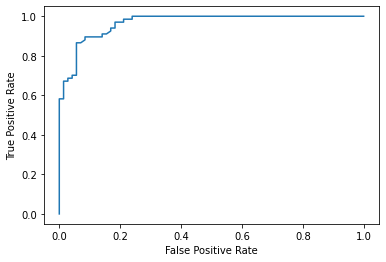

In [68]:
# roc auc curve for final model

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)

plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()